## 1 初始准备
### 1.1 读入数据
数据分为训练数据集（2013-2016年）和测试数据集（2017年）

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv("D:/ai/train1000.csv")
test = pd.read_csv("D:/ai/test1000.csv")
# 输入条件的范围
all_X = pd.concat((train.loc[:, 'solar term':'people'],
                      test.loc[:, 'solar term':'people']))
                      

In [2]:
test.head()

,date,solar term,day,small wind,middle wind,big wind,th.taibei,tl.taibei,r.taibei,th.taoyuan,...,tl.gaoxiong,r.gaoxiong,th.xinzhu,tl.xinzhu,r.xinzhu,GDP,industry,bdt,CPI,people
0,2017/1/1,dongzhi,holiday,0,0,0,25,17,0.0,26,...,18,0.0,25,17,0.0,4297549,104.62,5714,100.32,23543346
1,2017/1/2,dongzhi,holiday,0,0,0,25,19,0.0,26,...,18,0.0,25,19,0.0,4297549,104.62,5714,100.32,23543346
2,2017/1/3,dongzhi,work,0,0,0,24,20,0.6,26,...,19,0.0,24,20,0.0,4297549,104.62,5714,100.32,23543346
3,2017/1/4,dongzhi,work,0,0,0,25,18,0.0,26,...,19,0.0,25,18,0.2,4297549,104.62,5714,100.32,23543346
4,2017/1/5,dongzhi,work,0,0,0,27,17,0.0,26,...,20,0.0,27,17,0.0,4297549,104.62,5714,100.32,23543346


In [3]:
train.head()

,date,solar term,day,small wind,middle wind,big wind,th.taibei,tl.taibei,r.taibei,th.taoyuan,...,r.gaoxiong,th.xinzhu,tl.xinzhu,r.xinzhu,GDP,bdt,industry,CPI,people,electric
0,2013/1/1,dongzhi,holiday,0,0,0,17.0,15.0,10.5,17,...,0.0,17,15,1.9,3682257,4059,102.74,97.45,23324092,22390.28
1,2013/1/2,dongzhi,work,0,0,0,20.0,15.0,1.0,20,...,0.0,20,15,0.2,3682257,4059,102.74,97.45,23324092,25210.44
2,2013/1/3,dongzhi,work,1,0,0,17.0,13.0,15.5,17,...,0.0,17,13,4.4,3682257,4059,102.74,97.45,23324092,25452.21
3,2013/1/4,dongzhi,work,1,0,0,17.0,14.0,4.5,17,...,0.0,17,14,1.7,3682257,4059,102.74,97.45,23324092,25561.65
4,2013/1/5,dongzhi,weekend,1,0,0,19.0,15.0,2.0,19,...,0.0,19,15,2.4,3682257,4059,102.74,97.45,23324092,24112.83


#### 数据标签说明
solar term：节气

day：日期类型，包含Sholiday 春节假日，holiday 公众假日，work 工作日，weekend 周末

small/middle/big wind：分别对应 轻度/中度/强烈的台风

?.city：th代表最高温度（℃），tl代表最低温度（℃），r代表降雨量（mm）

GDP：代表地区生产总值（新台币百万元）

industry：工业生产指数

bdt：半导体产业产值（新台币亿元）

CPI：居民消费价格指数

people：人口数

electric：单日最大负荷（MW）

In [4]:
train.shape

(1461, 30)

In [5]:
test.shape

(365, 29)

### 1.2 预处理数据

使用pandas对数值特征做标准化处理：

In [6]:
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x - x.mean())
                                                            / (x.std()))

把离散数据点转换成数值标签

In [7]:
all_X = pd.get_dummies(all_X, dummy_na=True)

把缺失数据用本特征的平均值估计

In [8]:
all_X = all_X.fillna(all_X.mean())

In [9]:
num_train = train.shape[0]

X_train = all_X[:num_train].as_matrix()
X_test = all_X[num_train:].as_matrix()
y_train = train.electric.as_matrix()

### 1.3 导入NDArray格式数据

In [10]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)

## 2 机器学习模型
### 2.1 定义损失函数
使用平方误差作为损失函数，该函数可计算模型为有标签样本预测的值和标签的实际值之差的平方。由于取平方值，因此该损失函数会放大不佳预测的影响。也就是说，与 L1 损失函数相比，平方损失函数对离群值的反应更强烈。

In [11]:
square_loss = gluon.loss.L2Loss()

In [12]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

### 2.2 神经网络
使用神经元作为节点连接输入和输出构成神经网络模型

在上一层隐藏层中的各个节点的值传递到下一层进行加权求和之前，需要采用一个非线性函数对其进行了转换。这种非线性函数称为激活函数

使用RELU作为激活函数：F(x)=max(0,x)

In [13]:
def get_net():
    net = gluon.nn.Sequential()
    
    with net.name_scope():
        
        net.add(gluon.nn.Dense(20, activation="relu"))
        net.add(gluon.nn.Dense(20, activation="relu"))
        net.add(gluon.nn.Dense(20, activation="relu"))
        net.add(gluon.nn.Dense(20, activation="relu"))
        net.add(gluon.nn.Dense(20, activation="relu"))
        
        net.add(gluon.nn.Dense(17, activation="relu"))
        net.add(gluon.nn.Dense(17, activation="relu"))
        net.add(gluon.nn.Dense(17, activation="relu"))
        net.add(gluon.nn.Dense(17, activation="relu"))
        
        net.add(gluon.nn.Dense(13, activation="relu"))
        net.add(gluon.nn.Dense(13, activation="relu"))
        net.add(gluon.nn.Dense(13, activation="relu"))
        net.add(gluon.nn.Dense(13, activation="relu"))
        
        net.add(gluon.nn.Dense(10, activation="relu"))
        net.add(gluon.nn.Dense(10, activation="relu"))
        net.add(gluon.nn.Dense(10, activation="relu"))
        
        
        net.add(gluon.nn.Dense(5, activation="relu"))
        net.add(gluon.nn.Dense(5, activation="relu"))
        
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

## 3 核心程序设计
### 3.1 训练函数和正则化

In [14]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import matplotlib.pyplot as plt

def train(net, X_train, y_train, X_test, y_test, epochs,
          verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 110
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

### 3.2 K折交叉验证

将全部训练集S分成 k个不相交的子集，假设S中的训练样例个数为m，那么每一个子集有 m/k 个训练样例，相应的子集称作 {s1,s2,…,sk}

每次从分好的子集中里面，拿出一个作为测试集，其它k-1个作为训练集

In [15]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test,
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

### 3.3 参数自定义
一种通过计算并且减小梯度将损失降至最低的技术，它以训练数据为条件，来计算损失相对于模型参数的梯度。通俗来说，梯度下降法以迭代方式调整参数，逐渐找到权重和偏差的最佳组合，从而将损失降至最低。

在训练模型时用于梯度下降的一个变量。在每次迭代期间，梯度下降法都会将学习速率与梯度相乘。得出的乘积称为梯度步长。

权值衰减的作用是调节模型复杂度对损失函数的影响，若权值衰减很大，则复杂的模型损失函数的值也就大

In [16]:
# K个样本集合
k = 5
# 训练次数和显示截止的次数
epochs = 100
verbose_epoch = 95
# 学习率
learning_rate = 0.01
# 权值衰减
weight_decay = 0.01

## 4 程序运行
### 4.1 训练模型并输出误差曲线

Epoch 96, train loss: 0.035804
Epoch 97, train loss: 0.029058
Epoch 98, train loss: 0.025923
Epoch 99, train loss: 0.027781


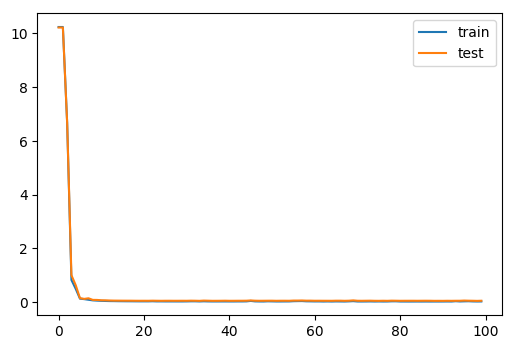

Test loss: 0.054463
Epoch 96, train loss: 0.025420
Epoch 97, train loss: 0.026909
Epoch 98, train loss: 0.029939
Epoch 99, train loss: 0.026149


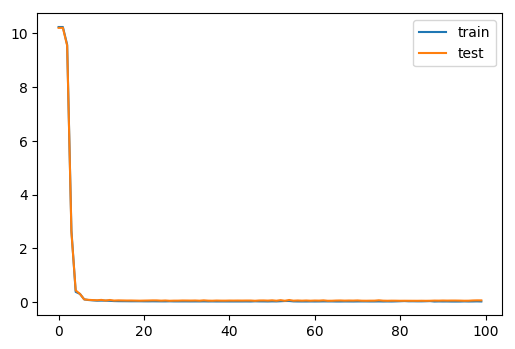

Test loss: 0.066982
Epoch 96, train loss: 0.024341
Epoch 97, train loss: 0.023748
Epoch 98, train loss: 0.024931
Epoch 99, train loss: 0.024427


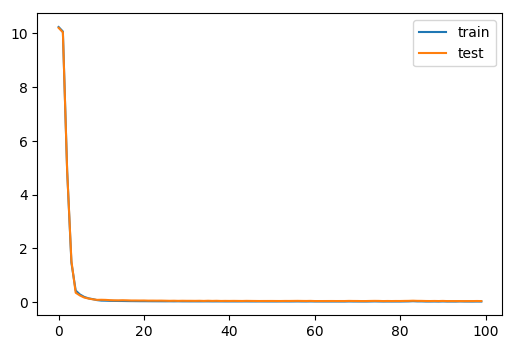

Test loss: 0.041718
Epoch 96, train loss: 0.023528
Epoch 97, train loss: 0.025203
Epoch 98, train loss: 0.023518
Epoch 99, train loss: 0.025553


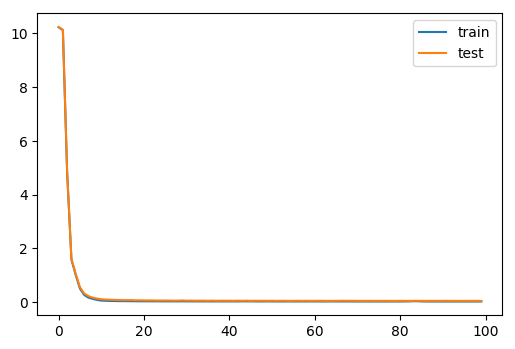

Test loss: 0.047963
Epoch 96, train loss: 0.022371
Epoch 97, train loss: 0.023213
Epoch 98, train loss: 0.027294
Epoch 99, train loss: 0.024109


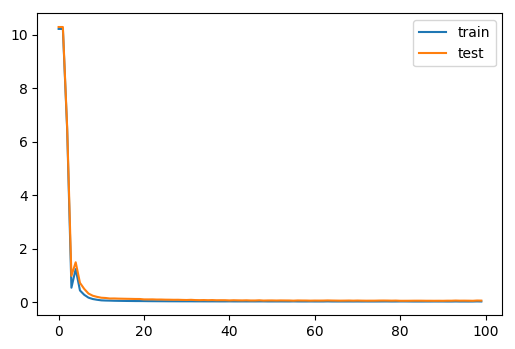

Test loss: 0.057521
5-fold validation: Avg train loss: 0.025604, Avg test loss: 0.053729


In [17]:
train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

### 4.2 输出结果并保存在本地

In [18]:
def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch,
          learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    test['electric'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['date'], test['electric']], axis=1)
    submission.to_csv('D:/ai/submission8.csv', index=False)

### 4.3 训练结果曲线

Epoch 96, train loss: 0.074034
Epoch 97, train loss: 0.074046
Epoch 98, train loss: 0.042875
Epoch 99, train loss: 0.035475


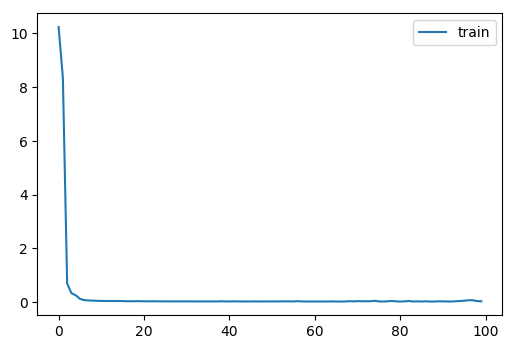

In [19]:
learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
      weight_decay)